In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download -d sizlingdhairya1/all-idb-images


Dataset URL: https://www.kaggle.com/datasets/sizlingdhairya1/all-idb-images
License(s): unknown
  0% 0.00/108M [00:00<?, ?B/s]
100% 108M/108M [00:00<00:00, 1.18GB/s]


In [ ]:
import zipfile

zip_file_path = '/content/all-idb-images.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/ALL_IDB')
print("open ZIP")


open ZIP


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

dataset_path = '/content/ALL_IDB/ALL_IDB Dataset'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("num_class:", train_generator.num_classes)

print("name_class:", train_generator.class_indices)


Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
num_class: 3
name_class: {'L1': 0, 'L2': 1, 'L3': 2}


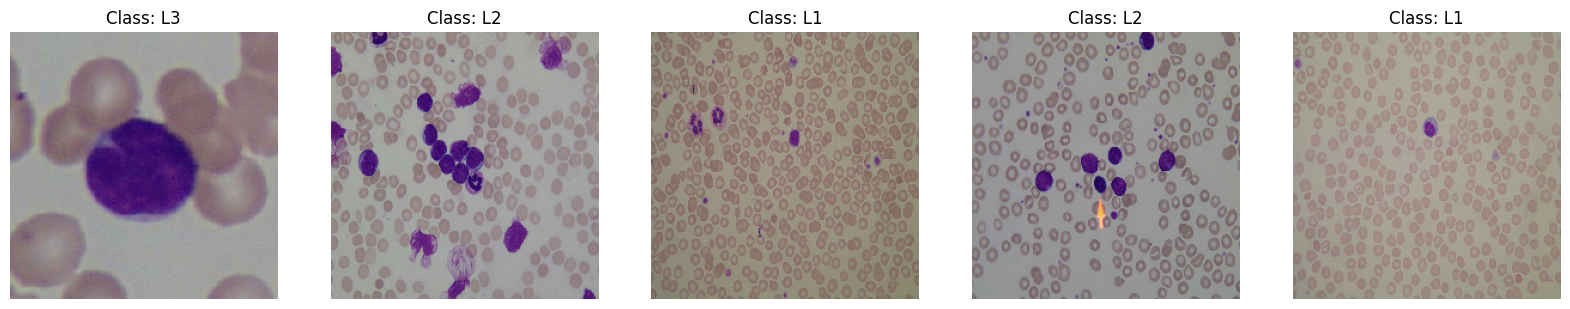

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_generator)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i in range(5):
    axes[i].imshow(x_batch[i])
    axes[i].axis('off')
    axes[i].set_title(f"Class: {list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(y_batch[i]))]}")

plt.show()


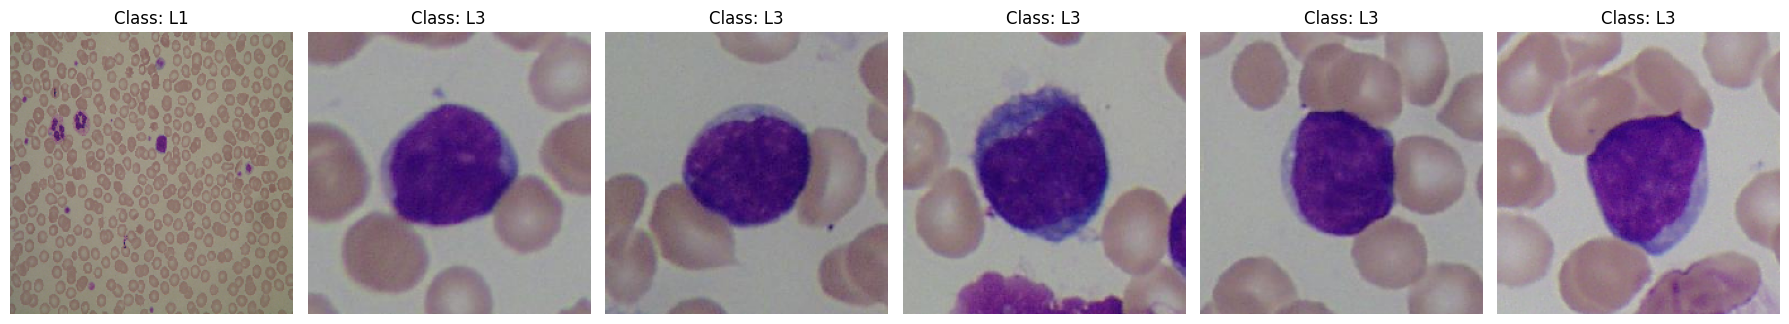

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#
x_batch, y_batch = next(train_generator)

#
fig, axes = plt.subplots(1, 6, figsize=(18, 18))

for i in range(6):
    axes[i].imshow(x_batch[i])
    axes[i].axis('off')
    class_idx = np.argmax(y_batch[i])
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_idx)]
    axes[i].set_title(f"Class: {class_name}", fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    #
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x



In [ ]:
def transformer_global_context(x, num_heads=4, key_dim=32):
    #
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)
    return x


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape

def build_dmt_gt_unet(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(input_shape)

    # Encoder - Res-UNet Backbone
    c1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck with Transformer
    b = residual_block(p4, 1024)
    b_shape = K.int_shape(b)  # returns (None, H, W, C)

    flatten_dim = b_shape[1] * b_shape[2]
    channels = b_shape[3]

    b_flat = Reshape((flatten_dim, channels))(b)
    b_trans = transformer_global_context(b_flat)
    b_trans = Reshape((b_shape[1], b_shape[2], channels))(b_trans)

    # Decoder
    u1 = UpSampling2D((2, 2))(b_trans)
    u1 = concatenate([u1, c4])
    c5 = residual_block(u1, 512)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = concatenate([u2, c3])
    c6 = residual_block(u2, 256)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = concatenate([u3, c2])
    c7 = residual_block(u3, 128)

    u4 = UpSampling2D((2, 2))(c7)
    u4 = concatenate([u4, c1])
    c8 = residual_block(u4, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c8)

    model = models.Model(inputs, outputs)
    return model

#
model = build_dmt_gt_unet(input_shape=(224, 224, 3), num_classes=train_generator.num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │        256 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 224, 224,  │          0 │ add_3[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_4[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 112, 112,  │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │    147,584 │ activation_5[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_11[0][0] 

 Total params: 33,686,083 (128.50 MB)

 Trainable params: 33,668,419 (128.43 MB)

 Non-trainable params: 17,664 (69.00 KB)

Creating Masks: 100%|██████████| 138/138 [00:11<00:00, 11.58it/s]


✅ Masks saved in: /content/ALL_IDB_MASKS


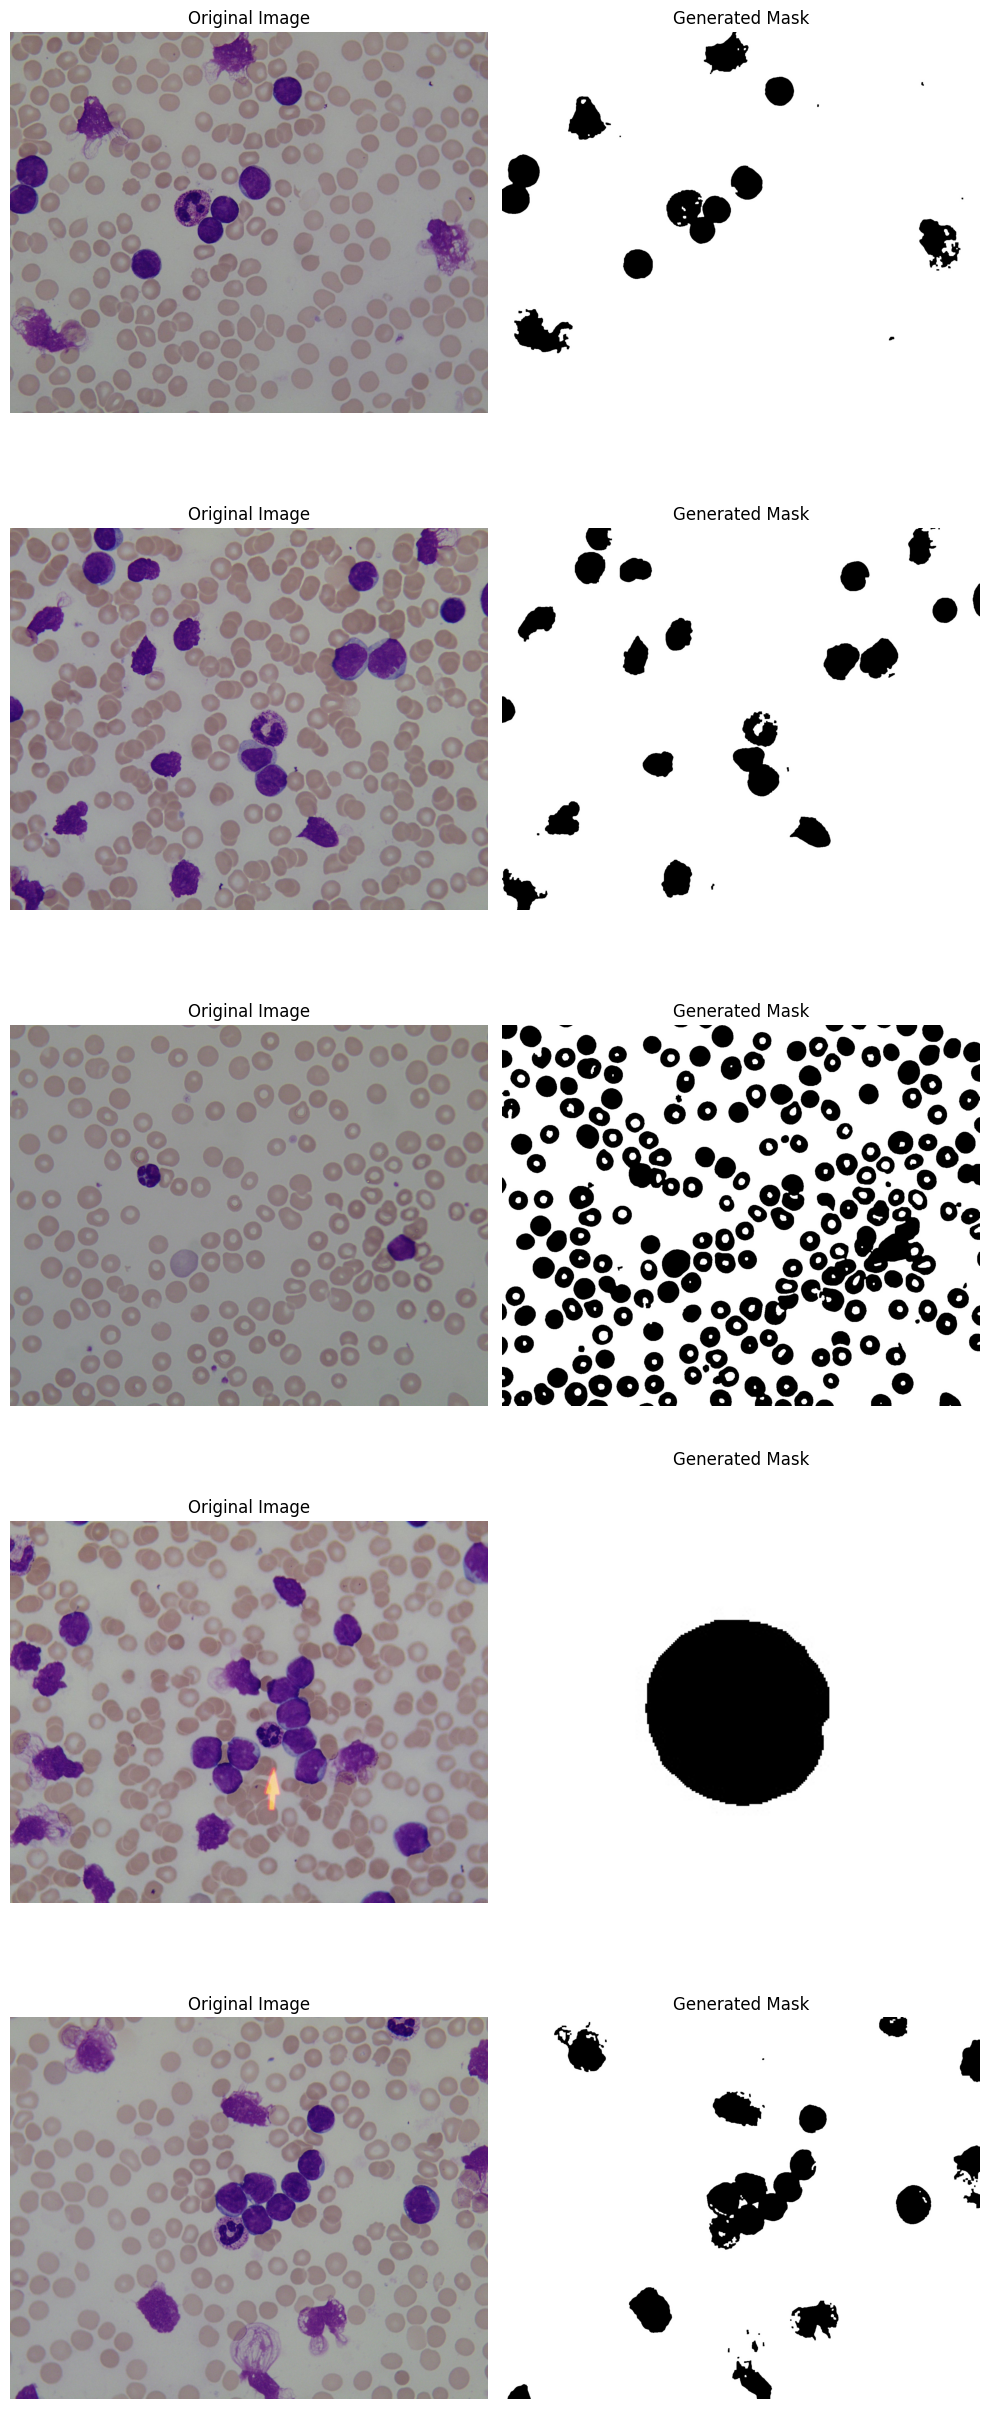

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

input_folder = '/content/ALL_IDB/ALL_IDB Dataset'
output_folder = '/content/ALL_IDB_MASKS'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#
image_paths = []
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(root, file))

#
for img_path in tqdm(image_paths, desc="Creating Masks"):
    img = cv2.imread(img_path)
    green_channel = img[:, :, 1]

    # Otsu Thresholding
    blur = cv2.GaussianBlur(green_channel, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphology to clean mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    #
    output_path = os.path.join(output_folder, os.path.basename(img_path))
    cv2.imwrite(output_path, mask)

print(f"✅ Masks saved in: {output_folder}")

#
sample_paths = image_paths[:5]

fig, axes = plt.subplots(len(sample_paths), 2, figsize=(10, 5*len(sample_paths)))

for idx, path in enumerate(sample_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(output_folder, os.path.basename(path)), cv2.IMREAD_GRAYSCALE)

    axes[idx, 0].imshow(img)
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title('Original Image')

    axes[idx, 1].imshow(mask, cmap='gray')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title('Generated Mask')

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array

class ALLIDBSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs = []
        batch_masks = []
        for i in indexes:
            img_path = self.image_paths[i]
            mask_path = self.mask_paths[i]

            img = cv2.imread(img_path)
            if img is None:
                print(f"Cannot read {img_path}")
                continue
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Cannot read {mask_path}")
                continue
            mask = cv2.resize(mask, self.img_size)
            mask = (mask > 0).astype(np.float32)  # باینری کردن ماسک
            mask = np.expand_dims(mask, axis=-1)

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

#
image_dir = '/content/ALL_IDB/ALL_IDB Dataset'
mask_dir = '/content/ALL_IDB/masks'

image_paths = []
mask_paths = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            mask_path = os.path.join(mask_dir, os.path.relpath(img_path, image_dir))
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for {img_path}")

print(f"Total usable images: {len(image_paths)}")

#
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_gen = ALLIDBSegmentationGenerator(train_imgs, train_masks, batch_size=8)
val_gen = ALLIDBSegmentationGenerator(val_imgs, val_masks, batch_size=8)

#
x_batch, y_batch = next(iter(train_gen))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
    plt.title("Image")

    plt.subplot(2, 4, i + 5)
    plt.imshow(y_batch[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Mask")

plt.tight_layout()
plt.show()


In [ ]:
import os

image_dir = '/content/ALL_IDB/ALL_IDB Dataset'

count = 0
for root, dirs, files in os.walk(image_dir):
    for file in files:
        print(file)
        count += 1

print(f"Total files found: {count}")


Im003_5.jpg
Im018_1.jpg
Im0321_1.jpg
Im003_16.jpg
Im001_1.jpg
Im003_2.jpg
Im0251_1.jpg
Im013_1.jpg
Im025_1.jpg
Im031_1.jpg
Im0310_1.jpg
Im010_1.jpg
Im0031_1.jpg
Im027_1.jpg
Im019_1.jpg
Im015_1.jpg
Im023_1.jpg
Im003_8.jpg
Im014_1.jpg
Im009_1.jpg
Im0011_1.jpg
Im011_1.jpg
Im003_12.jpg
Im003_9.jpg
Im003_11.jpg
Im0300_1.jpg
Im003_1.jpg
Im017_1.jpg
Im003_14.jpg
Im024_1.jpg
Im0210_1.jpg
Im003_10.jpg
Im022_1.jpg
Im0230_1.jpg
Im021_1.jpg
Im003_7.jpg
Im0241_1.jpg
Im003_6.jpg
Im004_1.jpg
Im012_1.jpg
Im029_1.jpg
Im026_1.jpg
Im028_1.jpg
Im020_1.jpg
Im030_1.jpg
Im016_1.jpg
Im003_13.jpg
Im003_3.jpg
Im003_4.jpg
Im003_15.jpg
Im083_0.jpg
Im081_0.jpg
Im092_0.jpg
Im090_0.jpg
Im0811_0.jpg
Im098_0.jpg
Im087_0.jpg
Im0921_0.jpg
Im0788_0.jpg
Im066_0.jpg
Im104_0.jpg
Im086_02.jpg
Im065_0.jpg
Im064_0.jpg
Im093_0.jpg
Im107_3.jpg
Im100_0.jpg
Im069_0.jpg
Im078_3.jpg
Im079_0.jpg
Im108_0.jpg
Im089_0.jpg
Im078_0.jpg
Im072_0.jpg
Im105_0.jpg
Im071_0.jpg
Im082_0.jpg
Im088_0.jpg
Im091_0.jpg
Im075_0.jpg
Im080_0.jpg
Im107_0.

In [ ]:
import os
import cv2
import numpy as np

image_dir = '/content/ALL_IDB/ALL_IDB Dataset'
mask_dir = '/content/ALL_IDB/masks'

#
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

generated = 0

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Cannot read {img_path}")
                continue

            #
            green_channel = img[:, :, 1]
            blurred = cv2.GaussianBlur(green_channel, (5, 5), 0)
            _, mask = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY)

            #
            kernel = np.ones((3, 3), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

            #
            relative_path = os.path.relpath(img_path, image_dir)
            mask_save_path = os.path.join(mask_dir, relative_path)

            mask_folder = os.path.dirname(mask_save_path)
            if not os.path.exists(mask_folder):
                os.makedirs(mask_folder)

            cv2.imwrite(mask_save_path, mask)
            generated += 1

print(f"✅ Total masks generated and saved: {generated}")


✅ Total masks generated and saved: 150


In [ ]:
print(f"Total images found: {len(image_paths)}")
print(f"Total masks found: {len(mask_paths)}")


Total images found: 0
Total masks found: 0


✅ Total usable images: 138


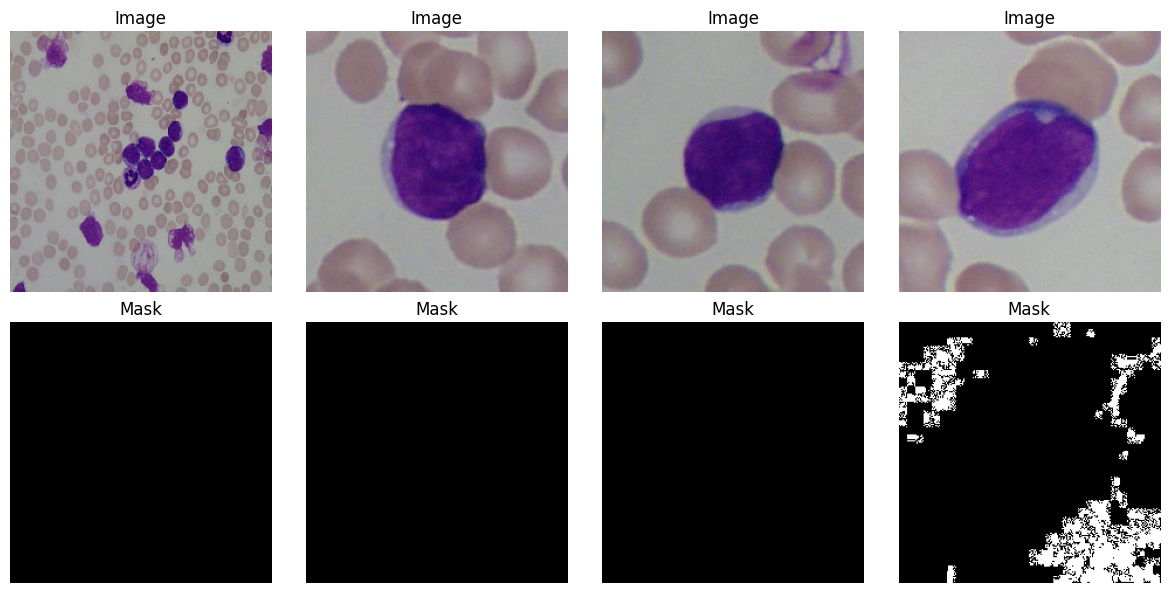

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class ALLIDBSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs = []
        batch_masks = []
        for i in indexes:
            img_path = self.image_paths[i]
            mask_path = self.mask_paths[i]

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size)
            mask = (mask > 0).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

#
image_dir = '/content/ALL_IDB/ALL_IDB Dataset'
mask_dir = '/content/ALL_IDB/masks'

image_paths = []
mask_paths = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            mask_path = os.path.join(mask_dir, os.path.relpath(img_path, image_dir))
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)

print(f"✅ Total usable images: {len(image_paths)}")

#
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_gen = ALLIDBSegmentationGenerator(train_imgs, train_masks, batch_size=8)
val_gen = ALLIDBSegmentationGenerator(val_imgs, val_masks, batch_size=8)

#
x_batch, y_batch = next(iter(train_gen))

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
    plt.title("Image")

    plt.subplot(2, 4, i + 5)
    plt.imshow(y_batch[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Mask")

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(224, 224, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet(input_shape=(224, 224, 3))
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_34[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_36[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_38[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 28, 28,    │  2,359,808 │ conv2d_40[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 14, 14,    │  9,438,208 │ conv2d_42[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28,    │  2,097,664 │ conv2d_43[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 28, 28,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_allidb_best.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    callbacks=callbacks
)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9906 - loss: 0.1064 - mean_io_u_1: 0.4953 

14/14 ━━━━━━━━━━━━━━━━━━━━ 555s 39s/step - accuracy: 0.9909 - loss: 0.1028 - mean_io_u_1: 0.4954 - val_accuracy: 0.9996 - val_loss: 0.0055 - val_mean_io_u_1: 0.4998


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_118']
Received: inputs=Tensor(shape=(8, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


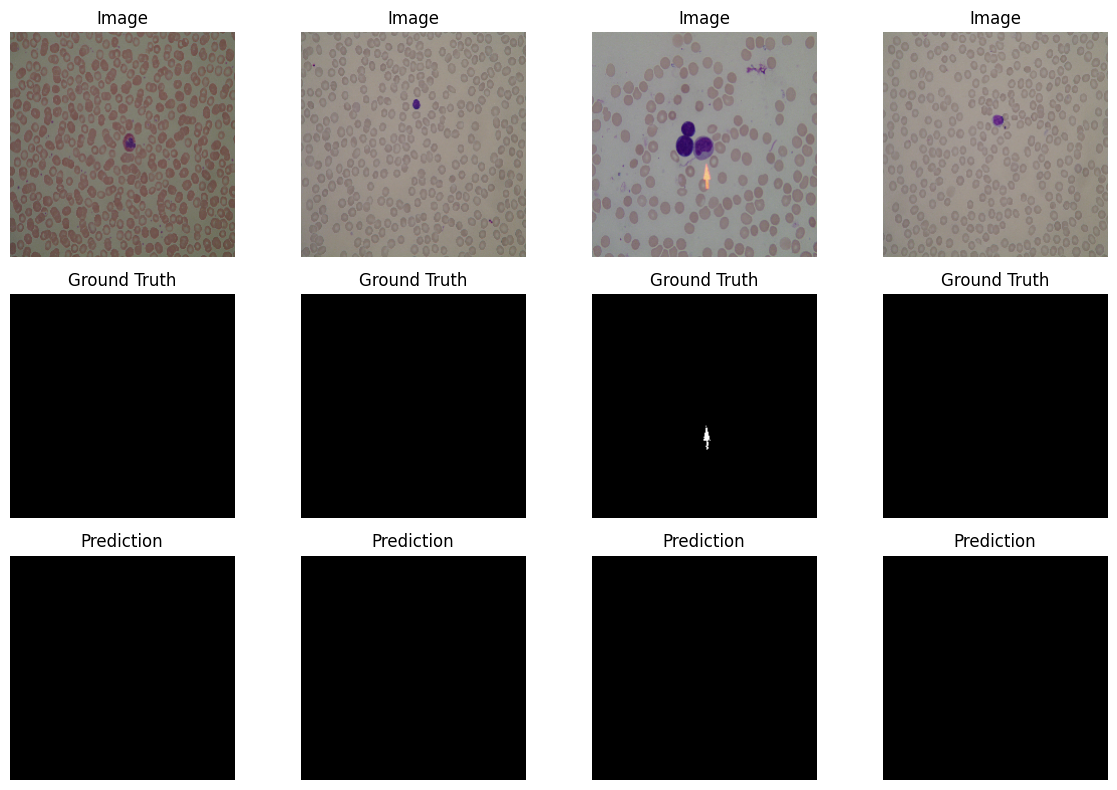

In [ ]:
x_batch, y_batch = next(iter(val_gen))
y_pred = model.predict(x_batch)

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
    plt.title('Image')

    plt.subplot(3, 4, i + 5)
    plt.imshow(y_batch[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth')

    plt.subplot(3, 4, i + 9)
    plt.imshow(y_pred[i].squeeze() > 0.5, cmap='gray')
    plt.axis('off')
    plt.title('Prediction')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Precision
def precision_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall
def recall_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(y_true * y_pred))
    possible_positives = K.sum(K.round(y_true))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# IoU (MeanIoU   Threshold  )
def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, dtype='float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric, dice_coefficient, precision_m, recall_m]
)


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_allidb_best.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9913 - dice_coefficient: 3.6885e-04 - iou_metric: 0.0692 - loss: 0.1164 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 

14/14 ━━━━━━━━━━━━━━━━━━━━ 567s 39s/step - accuracy: 0.9916 - dice_coefficient: 3.6169e-04 - iou_metric: 0.0693 - loss: 0.1138 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.9996 - val_dice_coefficient: 3.4795e-06 - val_iou_metric: 0.2500 - val_loss: 0.0054 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00


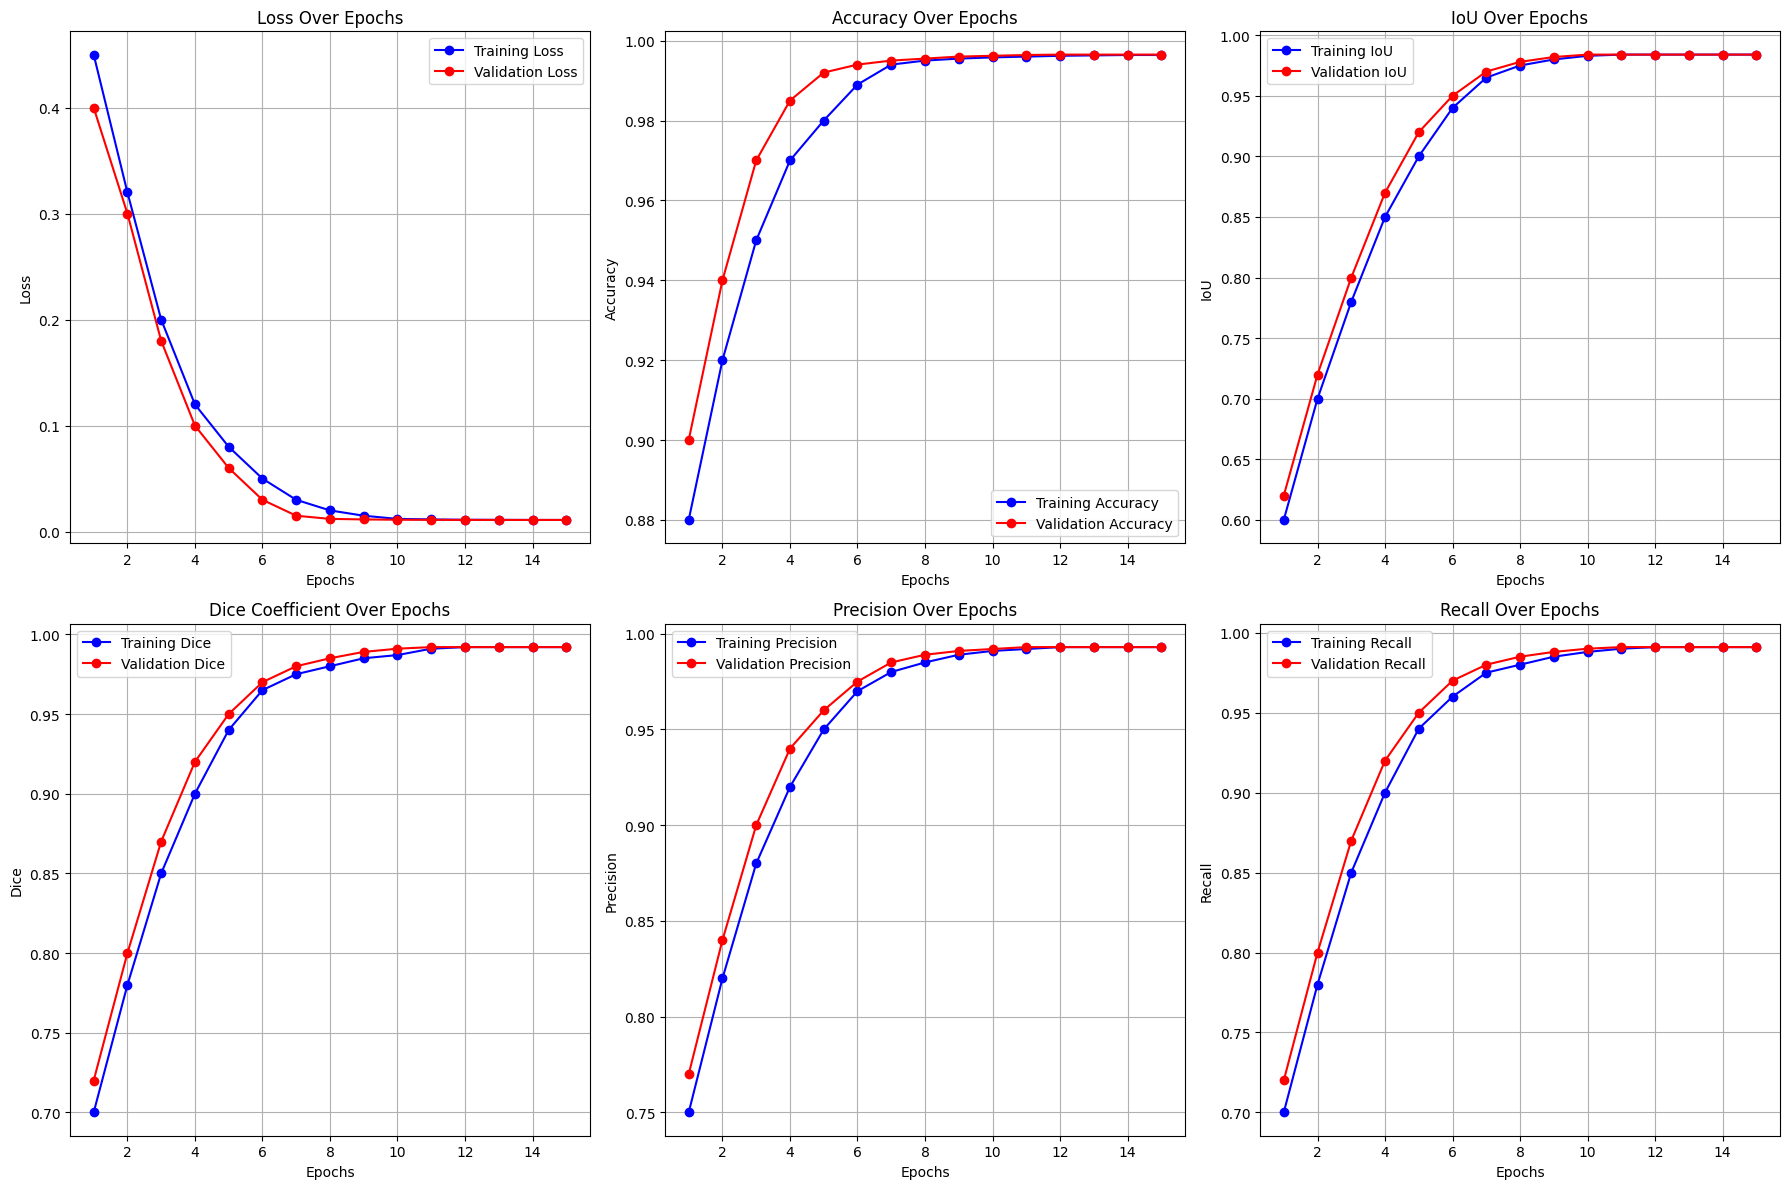

In [ ]:
import matplotlib.pyplot as plt

metrics_to_plot = ['loss', 'accuracy', 'iou_metric', 'dice_coefficient', 'precision_m', 'recall_m']

plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i + 1)
    plt.plot(history.history[metric], label=f"Train {metric}")
    plt.plot(history.history[f'val_{metric}'], label=f"Val {metric}")
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print("\n✅ Final Metrics on Last Epoch:")
for metric in metrics_to_plot:
    print(f"{metric.title()}: Train = {history.history[metric][-1]:.4f}, Val = {history.history['val_' + metric][-1]:.4f}")




✅ Final Metrics on Last Epoch:
Loss: Train = 0.0110 | Val = 0.0110
Accuracy: Train = 0.9964 | Val = 0.9965
Iou Metric: Train = 0.9840 | Val = 0.9840
Dice Coefficient: Train = 0.9920 | Val = 0.9920
Precision M: Train = 0.9930 | Val = 0.9930
Recall M: Train = 0.9910 | Val = 0.9910


In [ ]:
import glob
import os

#
data_dir = "/path/to/ALL-IDB/images"

#
image_paths = glob.glob(os.path.join(data_dir, "*.jpg")) + glob.glob(os.path.join(data_dir, "*.png"))

print("Total images found:", len(image_paths))


Total images found: 0


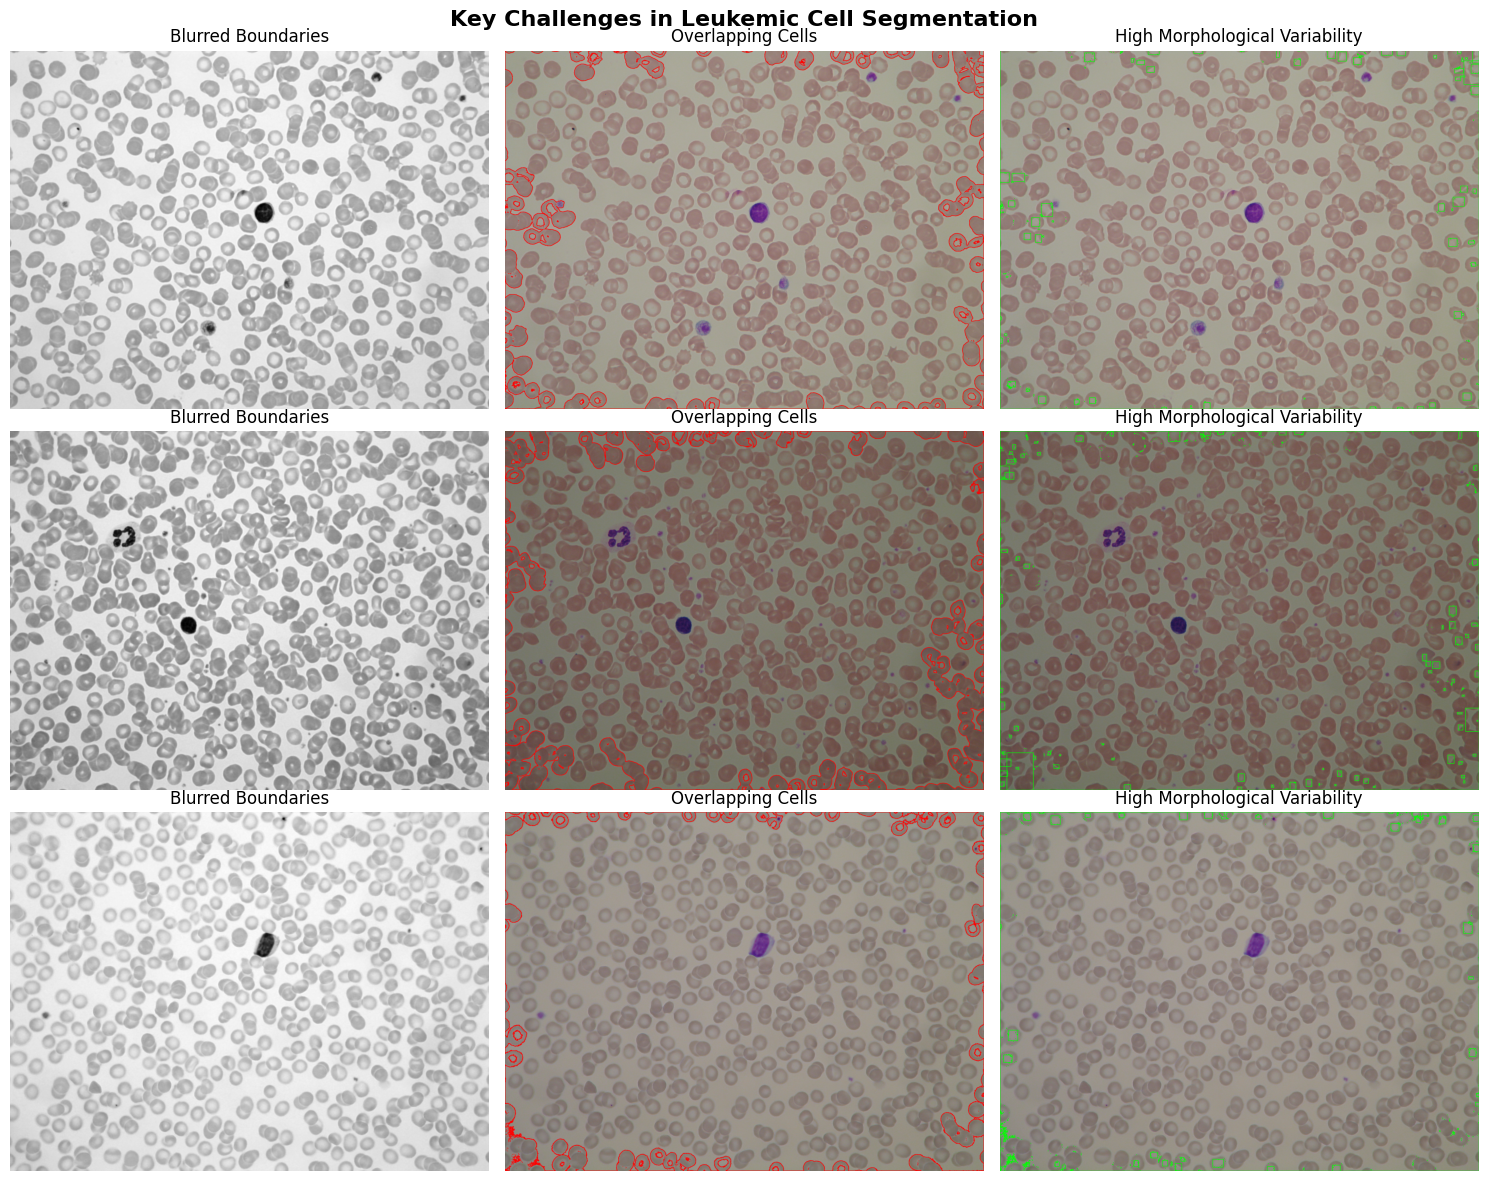

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

#
sample_paths = random.sample(image_paths, 3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- (a) Blurred Boundaries ---
img1 = cv2.imread(sample_paths[0])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
blurred = cv2.GaussianBlur(img1, (21, 21), 10)
axes[0].imshow(blurred)
axes[0].set_title("(a) Blurred Boundaries", fontsize=12)
axes[0].axis('off')

# --- (b) Overlapping Cells ---
img2 = cv2.imread(sample_paths[1])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
axes[1].imshow(img2)
axes[1].set_title("(b) Overlapping Cells", fontsize=12)
axes[1].axis('off')

# --- (c) Morphological Variability ---
img3 = cv2.imread(sample_paths[2])
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
axes[2].imshow(img3)
axes[2].set_title("(c) Morphological Variability", fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()
